# Interpolate between pairs of images
The code expects the script siren.py to be under '/content/drive/MyDrive/Colab Notebooks ' (or at the same folder if run locally) and the images to be under '/content/drive/MyDrive/Colab Notebooks/data/48/' (or under ./data/48 if run locally)
The network is built such that it expects image coordinates and an interpolation value as input and gives the pixel value in the form of RGBA in that coordinate for the interpolated image output. The grund truth of the interpolated image is calculates as image1*t+image2*(1-t)

Imports drive mount and cuda

In [1]:
import sys
import torch
import numpy as np
from PIL import Image
from skimage.io import imread_collection
from torchvision.transforms import Resize, Compose, ToTensor, Normalize
import matplotlib.pyplot as plt
from google.colab import drive
drive.mount('/content/drive')
sys.path.insert(0,'/content/drive/MyDrive/Colab Notebooks')
import siren
if torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")

Mounted at /content/drive


Get all images and calcualte mean and
Build the transform and the coordinates of the input

In [3]:
img_dir = '/content/drive/MyDrive/Colab Notebooks/data/48/*.png'
images = imread_collection(img_dir)
imagesData = np.stack([img for img in images])
mean = np.mean(imagesData, axis=(0, 1, 2)) / 255
std = np.std(imagesData, axis=(0, 1, 2)) / 255
transform = Compose([
    Resize(48),
    ToTensor(),
    Normalize(mean, std)
])
coords = siren.get_mgrid(48, 2)
coords = torch.cat([coords, torch.full((len(coords), 1), 0)], dim=1).to(device)
coords = torch.unsqueeze(coords, dim=0)

Get a pair of images and transform them

In [4]:
def get_images(i, j):
    return transform(Image.fromarray(images[i])).permute(1, 2, 0).view(-1, images[i].shape[-1]), transform(Image.fromarray(images[j])).permute(1, 2, 0).view(-1, images[j].shape[-1])

Train function
For each step, pick a random t, update the input with this t, and build the output image for this t.

In [5]:
def train(i, j):
    image1, image2 = get_images(i, j)

    img_siren = siren.Siren(in_features=3, out_features=4, hidden_features=256, hidden_layers=3, outermost_linear=True)
    img_siren.to(device)
    steps = 5000
    steps_til_summary = int(steps/ 5)

    optim = torch.optim.Adam(lr=1e-4, params=img_siren.parameters())
    model_input = coords.to(device)
    for step in range(steps):
        t = torch.rand(1)
        model_input[:,:,2]=t
        ground_truth = (image1*t.item()+image2*(1-t.item())).to(device)
        
        model_output, _ = img_siren(model_input)
        loss = ((model_output - ground_truth) ** 2).mean()

        if not step % steps_til_summary:
            print("Step %d, Total loss %0.6f" % (step, loss))
        optim.zero_grad()
        loss.backward()
        optim.step()
    return img_siren


Get two indices, train a model for those images and show 10 interpolated images between the two

In [6]:
def interpolate(i, j):
    model = train(i, j)
    j = np.linspace(0,1,10)
    fig, axes = plt.subplots(1,10, figsize=(18,18))
    for i in range(10):
        normalized_img = model(torch.cat([siren.get_mgrid(48, 2), torch.full((2304, 1), j[i])], dim=1).to(device))[0].view(48, 48, 4).cpu().detach().numpy()
        img = np.clip(255*(normalized_img * std + mean), 0,255).astype(np.int32)
        axes[i].imshow(img)
    plt.show()

Step 0, Total loss 1.259951
Step 1000, Total loss 0.000883
Step 2000, Total loss 0.003306
Step 3000, Total loss 0.000185
Step 4000, Total loss 0.006526


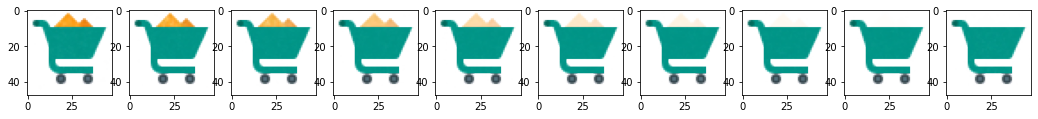

Step 0, Total loss 1.039610
Step 1000, Total loss 0.003396
Step 2000, Total loss 0.000625
Step 3000, Total loss 0.001296
Step 4000, Total loss 0.000415


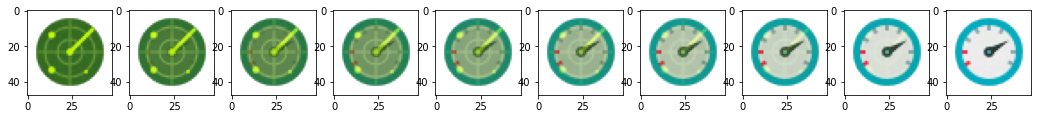

Step 0, Total loss 1.229219
Step 1000, Total loss 0.000998
Step 2000, Total loss 0.035936
Step 3000, Total loss 0.000178
Step 4000, Total loss 0.000240


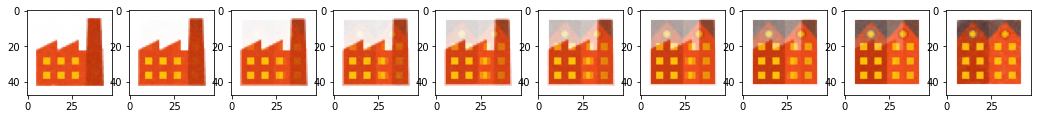

Step 0, Total loss 1.078564
Step 1000, Total loss 0.003031
Step 2000, Total loss 0.000427
Step 3000, Total loss 0.000383
Step 4000, Total loss 0.000303


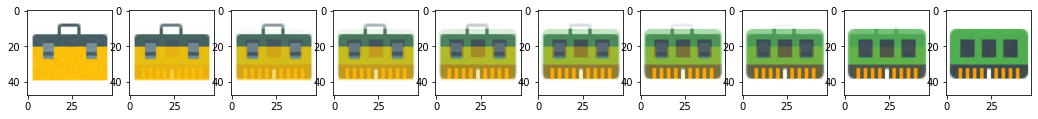

In [7]:
for i, j in [[85,86],[24,74],[0,31],[55,93]]:
    interpolate(i,j)